## Test the richness-concentration relation

First hypothesize that the upward trend with richness-concentration ($\beta > 0$) for high-z is the result of an upward mass concentration trend. Assuming that the concentration-formation time relation, richness-concentration relation stays the same, high mass clusters at the uptick regime would be earlier forming and have lower richnesses compared to their mid-mass counterparts. This hypothesis doesn't add up as we binned in narrow bins of mass and applied KLLR to smooth out any residual mass dependencies. 

A second hypothesis is with unrelaxed clusters. According to W.Lee+20, Ludlow+13, K.Wang+?? unrelaxed clusters experience a fluctuation in the concentration post major merger (a_MM) up to around 1 times the dynamical time after which the concentration increases with scale due to the cluster pseudo-evolution. In Ludlow, Lee they first experience a bounce (uptick) in concentration followed by a dip until they regress to normal; in Wang they first experience a gradual rise, then a dip then a bounce then regress to normal. The long term behavior is the same, and in both cases the concentration could be boosted up or down. What may be the case with K.Wang is a different definition of the event horizon of when the major merger occurs as the concentration ratio relative to the fiducial model is > 1 (gradual rise) before the snapshot of the major merger. This could correspond to the first peak in Lee and Ludlow. 

In [2]:
## Use the setup.py file to output directories. 
import sys
sys.path.append('/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/')

from setup import *
toolsdir = tools_dir()
repodir = repo_dir()
chainsdir = chains_dir()
datadir = data_dir()
plotdir = plots_dir()

sys.path.append(toolsdir)
sys.path.append(repodir)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.cm as cm
#from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import f_regression
from statsmodels.stats.anova import anova_lm
from statsmodels.compat import lzip
#sns.set()
#pd.set_option('display.notebook_repr_html', True)
#pd.set_option('display.precision', 2)
#%matplotlib notebook
#plt.rcParams['figure.figsize'] = 10, 10
from scipy.stats import norm
from scipy import stats

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
## KLLR setup
import sys
sys.path.append('/global/u1/z/zzhang13')

from kllr.kllr.regression_model import *
from kllr.kllr.regression_plotting import *
from kllr.kllr.calc_cov_KLLR import *

kllr_nbins= 20
kernel_type = 'gaussian'
kernel_width = 0.1

In [6]:
from data_bins import r_cent_lin_norm, r_cent_log_norm
from data_bins import mass_bins, mass_bin_cent
from data_bins import a_bins

## Halo catalog

In [55]:
with open(datadir + 'MDPL2_DS_R200c_SAGE_Ngal_allM_allz.p', 'rb') as f:
    matched_halo_df = pickle.load(f)

In [56]:
matched_halo_df.columns

Index(['id', 'Xoff', 'scale', 'CtreesHaloID', 'pid', 'mvir', 'rvir', 'rs', 'x',
       'y', 'z', 'Mmvir_all', 'M200b', 'M200c', 'M500c', 'T/|U|',
       'Halfmass_Scale', 'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir', 'R200c', 'R500c',
       'redshift', 'Ngal_Dsep_1', 'Ngal_Rvir', 'Ngal_R200c', 'Ngal_R500c',
       'sigma', 'r_range', 'delta_sigma'],
      dtype='object')

## Plot richness & Concentration
* Apply KLLR to remove mass dependency. This negates the hypothesis for the uptick in mass-concentration relations.
* Observe a positive trend between richness and concentration. 

In [57]:
## Create a function for plotting the richness-concentration by plugging in cur_df

def plot_richness_concentration(all_df, mass_min = 1e14, mass_max = 2e14, scale = 0.4922):
    ##Mask
    mask = (all_df.M200c >= mass_min) & (all_df.M200c < mass_max) & (all_df.scale == scale) 
    cur_df = all_df[mask]
    
    ### Use KLLR
    lm  = kllr_model(kernel_type=kernel_type, kernel_width=kernel_width)
    xline, yline, intercept, slopes, scatter, skew, kurt = lm.fit(np.log10(cur_df.M200c), np.log10(cur_df.Ngal_R200c.values), \
                                                                  bins=kllr_nbins, kernel_width=kernel_width, kernel_type=kernel_type, nBootstrap=1) 

    dy_kllr = lm.residuals(np.log10(cur_df.M200c), np.log10(cur_df.Ngal_R200c.values), bins=kllr_nbins, nBootstrap = 1,
                              fast_calc = False, verbose = False, kernel_type=kernel_type, kernel_width=kernel_width)
    
    ##Apply linear regression
    X_params =['c_vir']
    X = cur_df[X_params]
    X = sm.add_constant(X)
    y = np.array(dy_kllr,dtype=float)
    mreg = sm.OLS(y, X).fit()

    ## Plotting
    sm.graphics.plot_ccpr(mreg, "c_vir")
    plt.show()
    
    return

In [9]:
##Mask in mass, redshift bin
mass_min = 1e13; mass_max = 2e14; scale = 0.4922
#a_bins = [1, 0.6712, 0.4922]
mask = (matched_halo_df.M200c >= mass_min) & (matched_halo_df.M200c < mass_max) & (matched_halo_df.scale == scale) 
cur_df = matched_halo_df[mask]

In [10]:
### Use KLLR
lm  = kllr_model(kernel_type=kernel_type, kernel_width=kernel_width)
xline, yline, intercept, slopes, scatter, skew, kurt = lm.fit(np.log10(cur_df.M200c), np.log10(cur_df.Ngal_R200c.values), \
                                                              bins=kllr_nbins, kernel_width=kernel_width, kernel_type=kernel_type, nBootstrap=1) 

dy_kllr = lm.residuals(np.log10(cur_df.M200c), np.log10(cur_df.Ngal_R200c.values), bins=kllr_nbins, nBootstrap = 1,
                          fast_calc = False, verbose = False, kernel_type=kernel_type, kernel_width=kernel_width)


Text(0, 0.5, 'Richness')

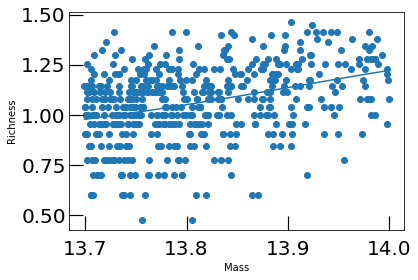

In [11]:
plt.scatter(np.log10(cur_df.M200c), np.log10(cur_df.Ngal_R200c.values))
plt.plot(xline, yline)
plt.xlabel('Mass')
plt.ylabel('Richness')

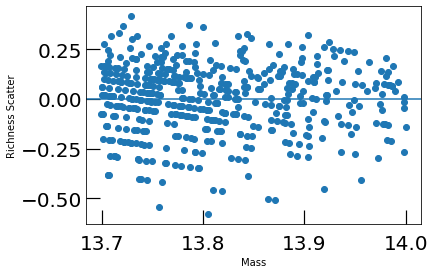

In [12]:
plt.scatter(np.log10(cur_df.M200c), dy_kllr)
plt.xlabel('Mass')
plt.ylabel('Richness Scatter')
plt.axhline(0)

In [13]:
## Linear regression between log10-richness-concentration

In [14]:
##Apply linear regression
X_params =['c_vir']
X = cur_df[X_params]
X = sm.add_constant(X)
y = np.array(dy_kllr,dtype=float)
mreg = sm.OLS(y, X).fit()

In [15]:
display(mreg.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     5.589
Date:                Tue, 14 Feb 2023   Prob (F-statistic):             0.0185
Time:                        06:42:16   Log-Likelihood:                 170.41
No. Observations:                 500   AIC:                            -336.8
Df Residuals:                     498   BIC:                            -328.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0545      0.024     -2.297      0.022      -0.101      -0.008
c_vir          0.0126      0.005      2.364      0.018       0.002       0.023
==============================================================================
Omnibus:                       21.353   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.013
Skew:                          -0.520   Prob(JB):                     1.01e-05
Kurtosis:                       3.148   Cond. No.                         14.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

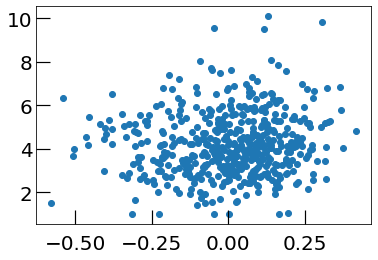

In [16]:
## Plot richness vs. concentration
plt.scatter(dy_kllr, cur_df.c_vir)

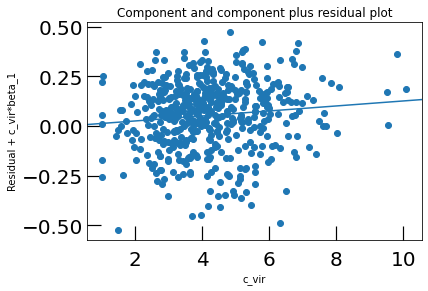

In [17]:
sm.graphics.plot_ccpr(mreg, "c_vir")
plt.show()

In [18]:
residuals = mreg.resid

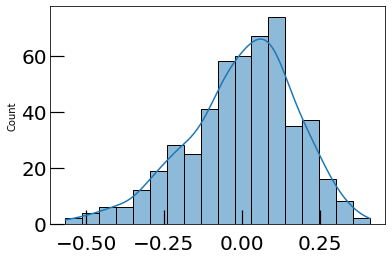

In [19]:
# Plot histogram of residuals
sns.histplot(residuals, kde=True)
plt.show()

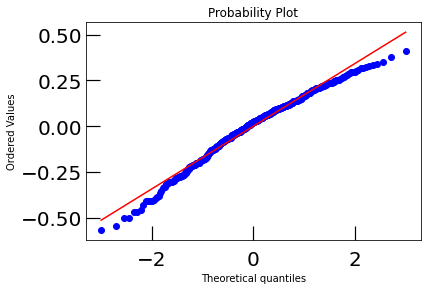

In [20]:
# Plot q-q plot of residuals
import pylab
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
plt.show()

## Testing Hypothesis 2
That the set of unrelaxed clusters are responsible for the uptick in richness-concentration. 
Split clusters into two samples -- relaxed and unrelaxed. 

* Test the residuals of relaxed and unrelaxed. Test by MAH_1dyn, T/U, Xoff

In [58]:
matched_halo_df.columns

Index(['id', 'Xoff', 'scale', 'CtreesHaloID', 'pid', 'mvir', 'rvir', 'rs', 'x',
       'y', 'z', 'Mmvir_all', 'M200b', 'M200c', 'M500c', 'T/|U|',
       'Halfmass_Scale', 'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir', 'R200c', 'R500c',
       'redshift', 'Ngal_Dsep_1', 'Ngal_Rvir', 'Ngal_R200c', 'Ngal_R500c',
       'sigma', 'r_range', 'delta_sigma'],
      dtype='object')

In [176]:
## Split the sample by Acc_Rate_1*Tdyn
from scipy import stats

bin_low = 0
bin_high = 50
mass_min = 5e13; mass_max = 1e14; scale = 0.4922
#a_bins = [1, 0.6712, 0.4922]


mask = (matched_halo_df.M200c >= mass_min) & (matched_halo_df.M200c < mass_max) & (matched_halo_df.scale == scale) 
cur_df = matched_halo_df[mask]


##Split the sample by column
column_name = 'Acc_Rate_1*Tdyn'
x_var = cur_df[column_name]
percentile_x_var = np.vectorize(lambda x: stats.percentileofscore(x_var, x))(x_var)
mask = (percentile_x_var >= bin_low) & (percentile_x_var < bin_high)
cur_df_low = cur_df[mask]
cur_df_high = cur_df[~mask]

In [177]:
print(len(cur_df_high))
print(len(cur_df_low))

251
249


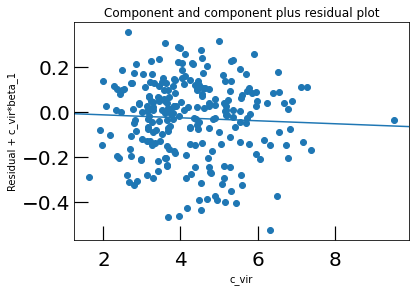

In [178]:
plot_richness_concentration(cur_df_low, mass_min = mass_min, mass_max = mass_max, scale = scale)

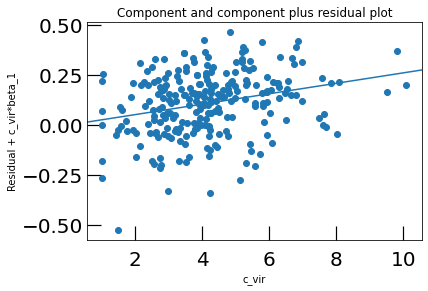

In [179]:
plot_richness_concentration(cur_df_high, mass_min = mass_min, mass_max = mass_max, scale = scale)